# Wikipedia Race

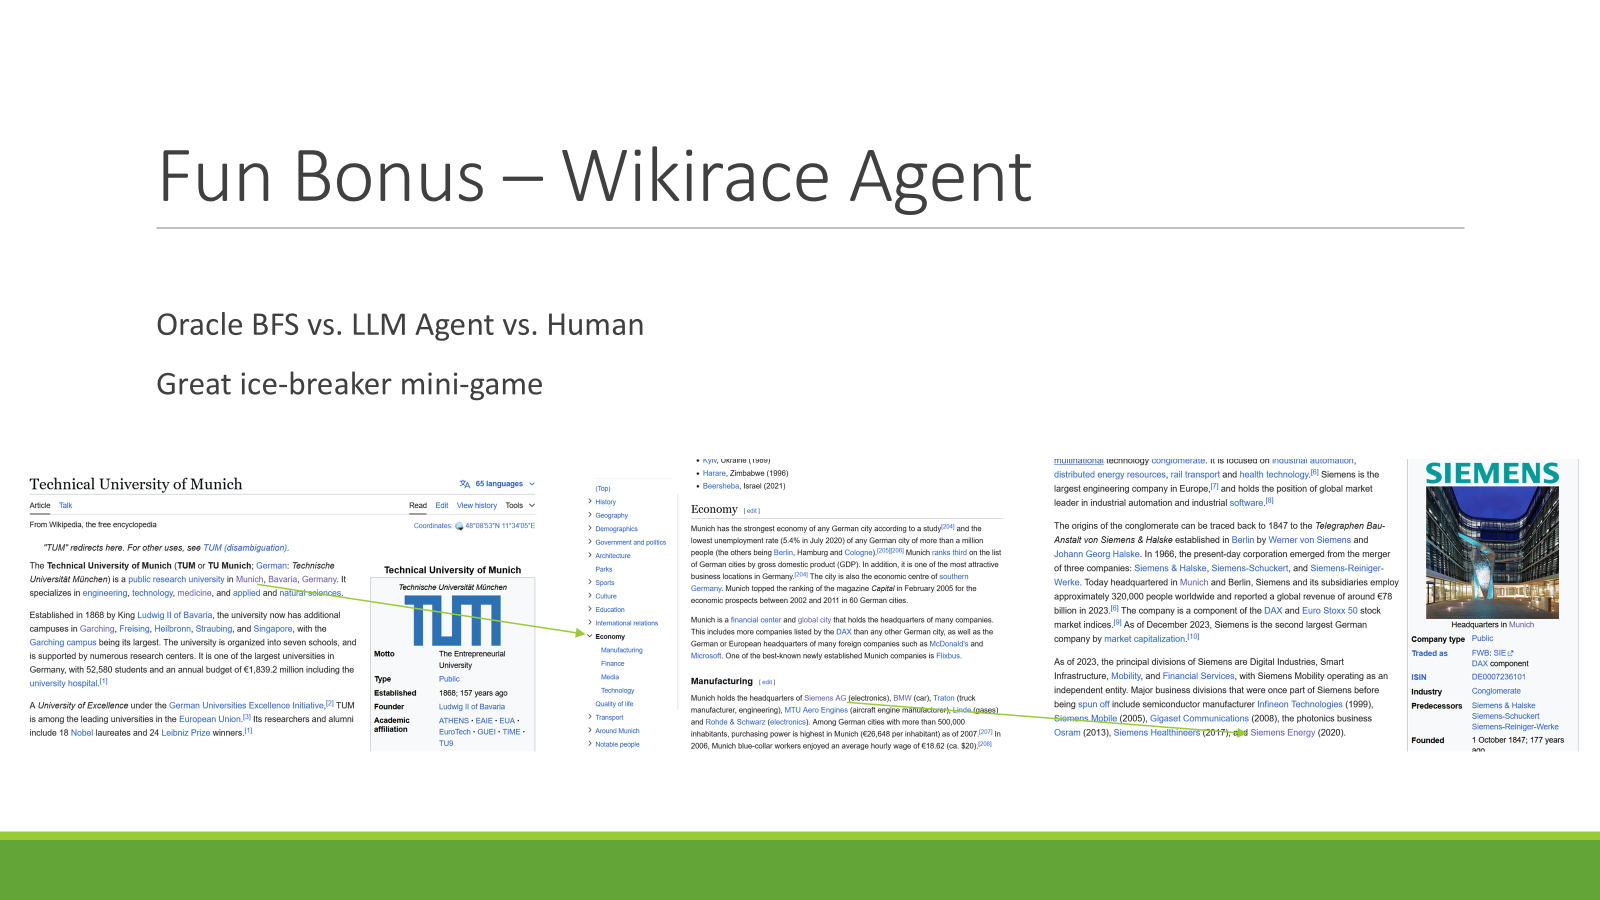

Jump directly to the WIKIRACE section to play

## Tests

In [54]:
!pip install -q wikipedia-api networkx tqdm


In [ ]:
#client = OpenAI(
#    base_url="https://openrouter.ai/api/v1",
#    api_key=api_key,
#)
#

In [ ]:
import wikipediaapi, networkx as nx, functools, time, random
from collections import deque
from tqdm.auto import tqdm
wiki = wikipediaapi.Wikipedia(user_agent="MyApp/1.0 (https://example.com; contact@example.com)")

# caching is optimal here cause some pages might be called multiple times
@functools.lru_cache(maxsize=50_000)
def get_page(title: str) -> wikipediaapi.WikipediaPage:
    return wiki.page(title)


def outbound_links(title: str, max_links=500):
    pg = get_page(title)
    if not pg.exists():
        return []
    links = [t for t, p in pg.links.items() #  skip talk, help, etc.
             if ':' not in t and p.ns == 0]
             
    return links#links[:max_links]

In [2]:
def shortest_wikirace(start: str, goal: str, max_depth=6) -> list[str] | None: # 6 can be increased but its enough for the tests i did
    """Return one shortest path (incl. start+goal) or None if not found ≤ max_depth."""
    if start == goal:
        return [start]

    # bidirectional BFS for speed !!!
    f_front, b_front   = {start}, {goal}
    f_parents, b_parents = {start: None}, {goal: None}
    depth = 0
    while f_front and b_front and depth < max_depth:
        depth += 1
        # expand smaller frontier first
        if len(f_front) <= len(b_front):
            next_front = set()
            for node in f_front:
                for nbr in outbound_links(node):
                    if nbr not in f_parents:
                        f_parents[nbr] = node
                        next_front.add(nbr)
                    if nbr in b_parents:
                        # meet in the middle
                        return _reconstruct(nbr, f_parents, b_parents)
            f_front = next_front
        else:
            next_front = set()
            for node in b_front:
                for nbr in outbound_links(node):
                    if nbr not in b_parents:
                        b_parents[nbr] = node
                        next_front.add(nbr)
                    if nbr in f_parents:
                        return _reconstruct(nbr, f_parents, b_parents)
            b_front = next_front
    return None

def _reconstruct(meet, f_parents, b_parents):
    path_f = []
    node = meet
    while node:
        path_f.append(node)
        node = f_parents[node]
    path_f.reverse()

    path_b = []
    node = b_parents[meet]
    while node:
        path_b.append(node)
        node = b_parents[node]
    return path_f + path_b


In [3]:
def play_wikirace(start: str, goal: str, agent_algorithm=shortest_wikirace):
    print(f"🎮  Wikirace:  {start}  ➜  {goal}\n")
    # Pre-compute agent path (may be None)
    agent_path = agent_algorithm(start, goal, max_depth=6)
    if agent_path is None:
        print("⚠️  Agent could not find a path ≤ 6 hops.")
    else:
        print(f"🤖 Agent shortest path length: {len(agent_path)-1}")

    human_path = [start]
    current = start
    while current != goal:
        print("\nYou are on:", current)
        links = outbound_links(current, max_links=100)
        print("Available links (first 50):")
        for i, link in enumerate(links, 1):
            print(f"{i:2d}. {link}")
        choice = input("Choose link number (or type title): ").strip()
        try:
            idx = int(choice) - 1
            next_page = links[idx]
        except ValueError:
            next_page = choice
        human_path.append(next_page)
        current = next_page

    print(f"\n🎉 You reached the goal in {len(human_path)-1} steps!")
    if agent_path:
        if len(agent_path) < len(human_path):
            print(f"🤖 Agent wins with {len(agent_path)-1} steps.")
        elif len(agent_path) > len(human_path):
            print("🙌 You beat the agent!")
        else:
            print("🤝 It's a tie!")
        print("Agent path:", " → ".join(agent_path))


In [64]:
start_page = "Machine learning"
target_page = "Artificial intelligence"
play_wikirace(start_page, target_page)


🎮  Wikirace:  Machine learning  ➜  Artificial intelligence

🤖 Agent shortest path length: 1

You are on: Machine learning
Available links (first 50):
 1. 15.ai
 2. AAAI Conference on Artificial Intelligence
 3. ACM Computing Classification System
 4. ACM Computing Surveys
 5. ADALINE
 6. AIXI
 7. AI alignment
 8. AI boom
 9. AI control problem
10. AI safety
11. AI takeover
12. AI winter
13. AT&T Labs
14. Accountability
15. Action selection
16. Activation function
17. Active learning (machine learning)
18. Adaptive website
19. Adobe Firefly
20. Adversarial machine learning
21. Affective computing
22. Agriculture
23. Alan Mackworth
24. Alan Turing
25. AlexNet
26. Alex Graves (computer scientist)
27. Alex Krizhevsky
28. Algorithm
29. Algorithm design
30. Algorithmic bias
31. Algorithmic efficiency
32. Algorithmic transparency
33. Allen Newell
34. AlphaFold
35. AlphaGo
36. AlphaZero
37. Amazon Machine Learning
38. Analysis of algorithms
39. Andrej Karpathy
40. Andrew Ng
41. Angoss
42. Anom

## WIKIRACE

In [ ]:
!conda env list

In [7]:
!pip -q install wikipedia-api networkx tqdm openai python-dotenv matplotlib

In [ ]:
import os, json, random, functools, time
import wikipediaapi, networkx as nx, matplotlib.pyplot as plt
from collections import deque
from tqdm.auto import tqdm
from dotenv import load_dotenv
import openai                                      # works with OpenRouter url
oracle_expansions = 0        # how many pages the oracle expanded
_COUNT_ORACLE     = False
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") or input("Paste your OpenRouter / OpenAI key: ")
openai.api_key = OPENAI_API_KEY
openai.base_url = "https://openrouter.ai/api/v1"  

In [8]:

LLM_MODEL = "meta-llama/llama-4-scout:free"     

wiki = wikipediaapi.Wikipedia(user_agent="MyApp/1.0 (https://example.com; contact@example.com)")
_COUNT_ORACLE = True
# --- 1. Wiki helpers ------------------------------------------------
@functools.lru_cache(50000)
def page(title):
    return wiki.page(title)

def outbound_links(title, limit=400):
    global oracle_expansions
    pg = page(title)
    if not pg.exists(): return []
    if _COUNT_ORACLE:                    # count only during BFS
        oracle_expansions += 1
    return [t for t, p in pg.links.items() if ":" not in t]#[:limit] #here TODO should we limit? i need more testsd

# --- 2. Oracle BFS (bidirectional) ----------------------------------
def bfs_shortest(start, goal, max_depth=6):
    global _COUNT_ORACLE, oracle_expansions
    _COUNT_ORACLE   = True          # start counting
    oracle_expansions = 0           # reset for this run
    try:
        if start==goal: return [start]
        f,b = {start},{goal}
        fp,bp={start:None},{goal:None}
        depth=0
        while f and b and depth<max_depth:
            depth+=1
            expand_f = len(f)<=len(b)
            cur = f if expand_f else b
            nxt=set()
            for node in cur:
                for nb in outbound_links(node):
                    par = fp if expand_f else bp
                    opp = bp if expand_f else fp
                    if nb not in par:
                        par[nb]=node
                        nxt.add(nb)
                    if nb in opp:
                        return _join(nb, fp, bp)
            if expand_f: f = nxt
            else: b = nxt
        return None
    finally:
        _COUNT_ORACLE = False    

def _join(meet, fp, bp):
    a=[]; n=meet
    while n: a.append(n); n=fp[n]
    a=a[::-1]; n=bp[meet]
    while n: a.append(n); n=bp[n]
    return a

# --- 3. LLM Agent ---------------------------------------------------
def llm_choose(current, goal, model=LLM_MODEL, top_k=40, temperature=0.3):
    links = outbound_links(current, top_k)
    prompt = f"""You are playing the Wikipedia Wikirace.
Current page: {current}
Target page: {goal}
Here are the first {len(links)} outbound link titles:
{json.dumps(links, indent=2)}

Pick the SINGLE link title you believe gets you closest to the target.
Reply ONLY with the exact title (case-sensitive)."""
    res = openai.chat.completions.create(
        model=model,
        messages=[{"role":"user","content":prompt}],
        temperature=temperature,
    )
    choice = res.choices[0].message.content.strip().splitlines()[0]
    if choice not in links:
        # fallback: random link
        choice = random.choice(links) if links else None
    return choice

def llm_path(start, goal, max_steps=10):
    path=[start]; cur=start
    for _ in range(max_steps):
        if cur==goal: break
        nxt = llm_choose(cur, goal)
        if not nxt or nxt in path: break
        path.append(nxt); cur=nxt
    return path if cur==goal else None

# --- 4. Human play --------------------------------------------------
def human_path(start, goal):
    path=[start]; cur=start
    while cur!=goal:
        links = outbound_links(cur, 200) # HERE
        print(f"\nYou are on: {cur}   (target: {goal})")
        for i,l in enumerate(links,1): print(f"{i:2d}. {l}")
        ch=input("Pick number or title (blank to abort): ").strip()
        if not ch: return None
        try: nxt=links[int(ch)-1]
        except (ValueError,IndexError): nxt=ch
        path.append(nxt); cur=nxt
    return path



In [9]:
# --- 5. One round ---------------------------------------------------
def wikirace_round(start, goal):
    from IPython.display import display        # ← fixed import
    import pandas as pd, matplotlib.pyplot as plt

    print(f"🏁  WIKIRACE   {start}  ➜  {goal}\n")

    # ---------- 1. Oracle -------------------------------------------
    print("🔍 Oracle (bidirectional BFS ≤6 hops) …")
    oracle = bfs_shortest(start, goal, max_depth=6)
    if oracle:
        print("  → found in", len(oracle) - 1, "hops")
    else:
        print("  → path not found")

    # ---------- 2. Gemini agent -------------------------------------
    print("\n🤖 Gemini agent thinking …")
    agent = llm_path(start, goal, max_steps=10)
    if agent:
        print("  → took", len(agent) - 1, "hops")
    else:
        print("  → failed within 10 steps")

    # ---------- 3. Human --------------------------------------------
    print("\n🚶 Your turn!")
    human = human_path(start, goal)
    if human:
        print("  → you took", len(human) - 1, "hops")
    else:
        print("  → aborted")

    # ---------- 4. Collect results ----------------------------------
    results = []
    for lab, p in [("Oracle", oracle), ("Gemini-LLM", agent), ("Human", human)]:
        if p:
            results.append({
                "Method": lab,
                "Hops":   len(p) - 1,
                "Path":   " → ".join(p)          # full path string
            })

    if not results:
        print("\nNo successful path to compare.  Game over.")
        return

    # rank by hop count (lower is better)
    results.sort(key=lambda d: d["Hops"])
    for i, r in enumerate(results, 1):
        r["Rank"] = i

    # ---------- 5. Pretty print paths --------------------------------
    print("\nPaths:")
    for r in results:
        print(f"[{r['Rank']}] {r['Method']:11s} ({r['Hops']} hops): {r['Path']}")

    # ---------- 6. Table ---------------------------------------------
    df = pd.DataFrame(results)[["Rank", "Method", "Hops", "Path"]]
    display(df.style.hide(axis="index"))

    # ---------- 7. Bar-chart -----------------------------------------
    plt.figure(figsize=(5, 2.5))
    bars = plt.bar(
        [r["Method"] for r in results],
        [r["Hops"]   for r in results],
        color=["grey", "#009999", "orange"][: len(results)],
    )
    plt.ylabel("Hops")
    plt.title("Wikirace – hop count by method")

    # annotate bars with hop numbers
    for bar, r in zip(bars, results):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.1,
            str(r["Hops"]),
            ha="center",
            va="bottom",
            fontsize=10,
        )
    plt.ylim(top=max(r["Hops"] for r in results) + 1)
    plt.show()

In [ ]:
# ---   Gemini LLM Agent -------------------------------------------

import requests
from collections import deque
from datetime import datetime, timedelta

GEMINI_MODEL   = "gemini-2.0-flash"  
with open("key.txt", "r") as f:
    GEMINI_API_KEY = f.readlines()[2].strip() # key.txt is in the same folder as this notebook but in gitignore!!!
# Google's published free-tier limits
REQS_PER_MIN   = 15
REQS_PER_DAY   = 1500

# counters for simple rate-limiting # TODO: added to avoid rate-limit errors (that i got with openrouter)
_request_log   = deque(maxlen=REQS_PER_MIN)   # timestamps of last minute’s requests
_today_count   = 0
_today_date    = datetime.utcnow().date()


In [11]:
def _respect_limits():
    """goal: stay  15 req/min and 1 500 req/day."""
    global _today_count, _today_date

    now = datetime.utcnow()
    if now.date() != _today_date:
        _today_date  = now.date()
        _today_count = 0
        _request_log.clear()

    if _today_count >= REQS_PER_DAY:
        raise RuntimeError("Daily Gemini quota (1 500 requests) exhausted.")

    while _request_log and (now - _request_log[0]) > timedelta(minutes=1):
        _request_log.popleft()
    if len(_request_log) >= REQS_PER_MIN:
        sleep_for = 60 - (now - _request_log[0]).total_seconds() + 0.1
        print(f"[rate-limit] Sleeping {sleep_for:0.1f} s to respect 15 req/min …")
        time.sleep(sleep_for)


In [12]:

def gemini_call(prompt: str,
                api_key: str = GEMINI_API_KEY,
                model  : str = GEMINI_MODEL,
                temp   : float = 0.3,
                max_out: int   = 64) -> str:
    """ wrapper around the Generative Language REST endpoint."""
    global _today_count   
    _respect_limits()

    url = (f"https://generativelanguage.googleapis.com/v1beta/models/"
           f"{model}:generateContent?key={api_key}")

    body = {
        "contents": [{"parts": [{"text": prompt}]}],
        "generationConfig": {"temperature": temp,
                             "maxOutputTokens": max_out}
    }
    r = requests.post(url, json=body, timeout=60) # !!!
    if r.status_code != 200:
        raise RuntimeError(f"Gemini error {r.status_code}: {r.text}")

    _today_count  += 1
    _request_log.append(datetime.utcnow())

    data = r.json()
    try:
        return data["candidates"][0]["content"]["parts"][0]["text"].strip()
    except (KeyError, IndexError):
        raise RuntimeError(f"Unexpected Gemini response: {data}")


In [13]:
def llm_choose(current, goal, top_k=60, temperature=0.3):
    links = outbound_links(current, top_k)
    prompt = f"""You are playing the Wikipedia Wikirace.
Current page: {current}
Target page: {goal}

Below is the first {len(links)} outbound link titles in JSON array form:
{json.dumps(links, indent=2)}

Choose **one** title that gets you closest to the target.
Reply with the exact title only."""
    try:
        choice = gemini_call(prompt, temp=temperature)
    except RuntimeError as e:
        print("[Gemini]", e)
        return random.choice(links) if links else None

    choice = choice.splitlines()[0].strip()
    if choice not in links:
        choice = random.choice(links) if links else None
    return choice



def llm_path(start, goal, max_steps=10):
    path = [start]
    cur  = start
    for _ in range(max_steps):
        if cur == goal:
            break
        nxt = llm_choose(cur, goal)
        if not nxt or nxt in path:
            break
        path.append(nxt)
        cur = nxt
    return path if cur == goal else None


### Let's play

🏁  WIKIRACE   Intelligent agent  ➜  National Football League

🔍 Oracle (bidirectional BFS ≤6 hops) …
  → found in 2 hops

🤖 Gemini agent thinking …
  → took 7 hops

🚶 Your turn!

You are on: Intelligent agent   (target: National Football League)
 1. AIXI
 2. AI alignment
 3. AI safety
 4. Agent-based computational economics
 5. Agent (economics)
 6. Agentic AI
 7. Alex Klokus
 8. Algorithmic bias
 9. AlphaZero
10. Amazon Alexa
11. Ambient intelligence
12. Anduril Industries
13. Anthropic
14. ArXiv (identifier)
15. Ars Technica
16. Artificial conversational entity
17. Artificial general intelligence
18. Artificial intelligence
19. Artificial intelligence systems integration
20. Artificial neural network
21. AutoGPT
22. Automated planning and scheduling
23. Autonomous agent
24. Basic Books
25. Belief–desire–intention software model
26. Benchmark (computing)
27. Bibcode (identifier)
28. Big Tech
29. Biome
30. Bloomberg News
31. Business Insider
32. ChatGPT Deep Research
33. Chinese room
3

Rank,Method,Hops,Path
1,Oracle,2,Intelligent agent → ISBN (identifier) → National Football League
2,Human,4,Intelligent agent → World Economic Forum → United Nations → United States → National Football League
3,Gemini-LLM,7,Intelligent agent → United States Department of Defense → Council of Economic Advisers → Economy → Consumer society → Advertising → American football → National Football League


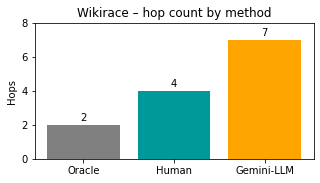

In [15]:
start = "Intelligent agent"
goal  = "National Football League"
wikirace_round(start, goal)

In [17]:
oracle_expansions

2

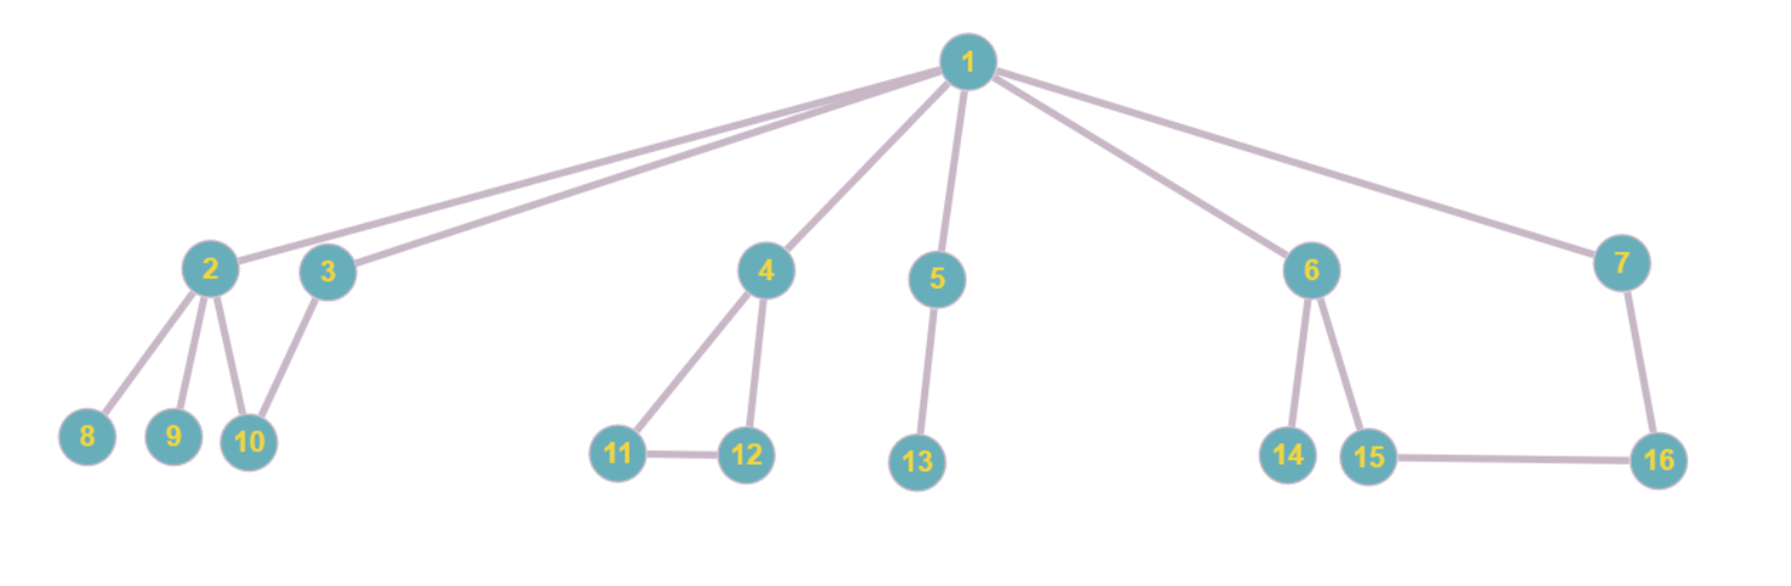

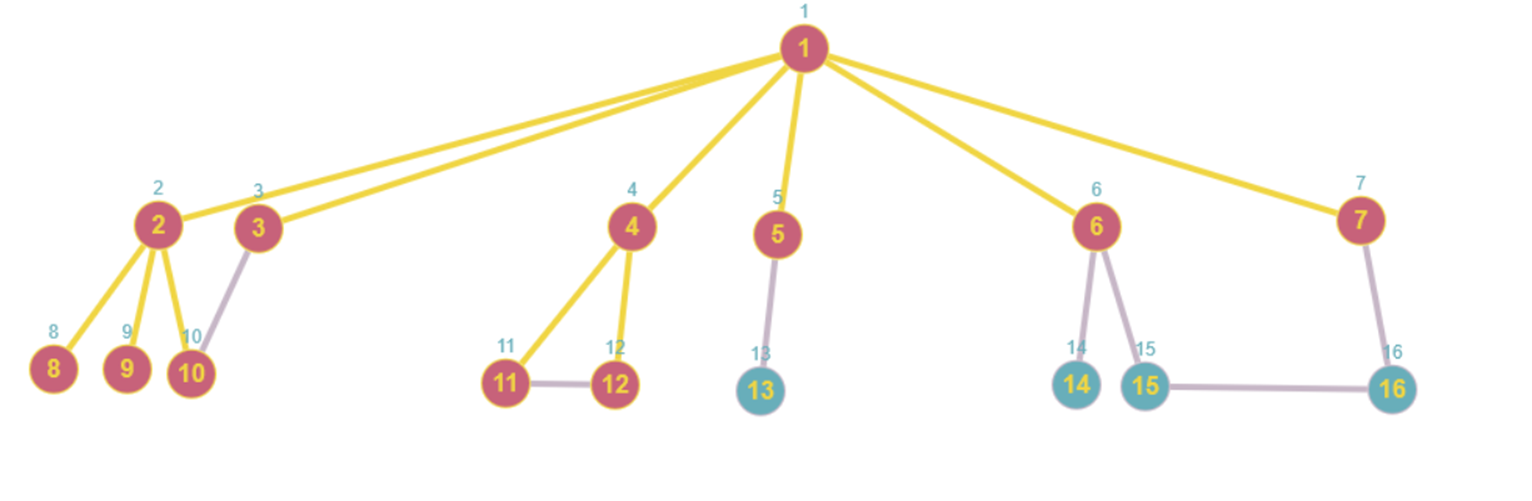